In [72]:
# 워터마크 불러오는 코드
%load_ext watermark
%watermark -v -p numpy,scipy,sklearn,pandas,matplotlib

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.7.6
IPython version      : 7.12.0

numpy     : 1.18.1
scipy     : 1.4.1
sklearn   : 0.22.1
pandas    : 1.0.1
matplotlib: 3.1.3



**3장 – 분류**

_이 노트북은 3장에 있는 모든 샘플 코드와 연습문제 해답을 가지고 있습니다._

# 설정

파이썬 2와 3을 모두 지원합니다. 공통 모듈을 임포트하고 맷플롯립 그림이 노트북 안에 포함되도록 설정하고 생성한 그림을 저장하기 위한 함수를 준비합니다:

In [73]:
# 파이썬 2와 파이썬 3 지원
from __future__ import division, print_function, unicode_literals

# 공통
import numpy as np
import os

# 일관된 출력을 위해 유사난수 초기화
np.random.seed(42)

# 맷플롯립 설정
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
matplotlib.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

# 그림을 저장할 폴드
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# MNIST

데이터셋을 내려받는 코드입니다.
`fetch_mldata`는 0.22 버전에서 삭제될 예정입니다. 0.20 버전에서 관련된 경고를 피하기 위해 대신 `fetch_openml` 함수를 사용하는 것이 좋습니다.

In [74]:
# 매우 많은 데이터를 가져와야 하므로 좀 느립니다.
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True)
# mnist

In [75]:
mnist

{'data': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'target': array(['5', '0', '4', ..., '4', '5', '6'], dtype=object),
 'frame': None,
 'feature_names': ['pixel1',
  'pixel2',
  'pixel3',
  'pixel4',
  'pixel5',
  'pixel6',
  'pixel7',
  'pixel8',
  'pixel9',
  'pixel10',
  'pixel11',
  'pixel12',
  'pixel13',
  'pixel14',
  'pixel15',
  'pixel16',
  'pixel17',
  'pixel18',
  'pixel19',
  'pixel20',
  'pixel21',
  'pixel22',
  'pixel23',
  'pixel24',
  'pixel25',
  'pixel26',
  'pixel27',
  'pixel28',
  'pixel29',
  'pixel30',
  'pixel31',
  'pixel32',
  'pixel33',
  'pixel34',
  'pixel35',
  'pixel36',
  'pixel37',
  'pixel38',
  'pixel39',
  'pixel40',
  'pixel41',
  'pixel42',
  'pixel43',
  'pixel44',
  'pixel45',
  'pixel46',
  'pixel47',
  'pixel48',
  'pixel49',
  'pixel50',


In [76]:
# 이미지가 70,000개 있고, 각 이미지에는 784개 의 특성이 있다. 이미지가 28 x 28이기 떄문이다.
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

In [77]:
28*28

784

수정된 내용
`fetch_mldata`는 0.22 버전에서 삭제될 예정입니다. 0.20 버전에서 관련된 경고를 피하기 위해 대신 `fetch_openml` 함수를 사용하는 것이 좋습니다. 아까 위에 올라간 소스와 같습니다.

In [78]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"]
y = y.astype(np.int)

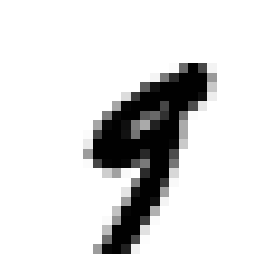

In [79]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
           interpolation="nearest")
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

In [80]:
# 숫자를 맞춰 보면 9가 나온다.
y[36000]

9

In [81]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [82]:
# 숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

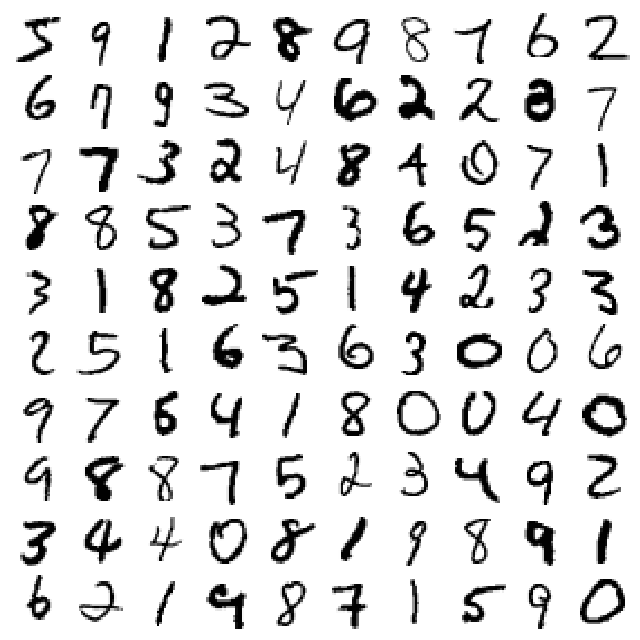

In [83]:
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

In [84]:
y[36000]

9

In [85]:
## 훈련 세트와 테스트 세트로 70,000개를 나누어 놓는다.
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [87]:
X.shape

(70000, 784)

In [88]:
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [89]:
shuffle_index

array([12628, 37730, 39991, ...,   860, 15795, 56422])

## 이진 분류기 훈련

In [99]:
# 이진 분류기 : 하나만 식별 (O / X)
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [100]:
# 확률적 경사 하강법 : Stochastic Gradient Descent
# 한 번에 하나씩 훈련 샘플을 독립적으로 처리한다. 그래서 SGD는 온라인 학습에 잘 들어맞는다.
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, random_state=42)
sgd_clf.fit(X_train, y_train_5)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [101]:
sgd_clf.predict([some_digit])

array([False])

In [102]:
some_digit

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   

In [106]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.964 , 0.9579, 0.9571])

In [107]:
# 교차 검증 구현
# 다음 소스는 사이킷런의 cross val score와 거의 같은 작업을 수행하고 동일한 결과를 출력한다.
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


0.964


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


0.9579
0.9571


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [108]:
# 모든 클래스가 5 아닌 것으로 분류하는 Never5Classifier
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [110]:
# 이렇게 해도 10개의 수 중에 5가 안 나올 확률은 90% 이므로 잘 맞히게 된다.
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.909  , 0.90745, 0.9125 ])

In [ ]:
## 3.3.2. 오차 행렬
분류기의 성능을 평가하는 더 좋은 방법으로 Confusion matrix를 활용할 수 있다.

In [112]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [113]:
from sklearn.metrics import confusion_matrix

# 오차 행렬에서 1899, 521 개의 데이터는 제대로 분류 못 한 것이다.
confusion_matrix(y_train_5, y_train_pred)

array([[54058,   521],
       [ 1899,  3522]], dtype=int64)

In [114]:
54058 + 521 + 1899 + 3522

60000

In [115]:
y_train_perfect_predictions = y_train_5

In [116]:
# 완벽한 분류(완벽할 수밖에 없는 행렬) 일 경우 54579를 정확하게 틀렸다고 판정, 5421을 정확하게 맞다고 판정
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

In [ ]:
[54579, 5421]
[0,  0]

In [117]:
54579 + 5421

60000

In [118]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)
# TP / TP + FP

0.8711352955725946

In [120]:
3522 / (3522 + 521)

0.8711352955725946

In [121]:
## 재현율 recall
## TP / TP + FN
recall_score(y_train_5, y_train_pred)

0.6496956281128943

In [122]:
3522 / (3522 + 1899)

0.6496956281128943

In [123]:
# F1 score 
# F1 = 정밀도와 재현율의 조화 평균
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7442941673710904

In [124]:
2 / (1 / 0.8711 + 1/ 0.6496)

0.7442185309396988

In [34]:
#### 정밀도와 재현율의 트레이드오프
* 재현율이 높을 필요가 있는 것 : cctv 도둑 잡기(일단 FN이 낮아서 양성을 많이 발견하는 것이 중요)
* 정밀도가 높을 필요가 있는 것 : 야한 동영상 필터링 (FP 가 극단적으로 낮아야 하는 것이 중요)

SyntaxError: invalid syntax (<ipython-input-34-e39c37665811>, line 2)

In [130]:
## 임곗값을 사용할 수 있다.
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([-400042.39513131])

In [131]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [132]:
y_some_digit_pred

array([False])

In [133]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [137]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


노트: 만약 사이킷런 0.19.0 버전을 사용하고 있다면 `method="decision_function"` 옵션으로 `cross_val_predict()` 함수를 사용할 때 이진 분류에서 1차원 배열이 아니고 2차원 배열을 반환하는 [버그](https://github.com/scikit-learn/scikit-learn/issues/9589)가 있습니다. 사이킷런 0.19.1로 업그레이드하거나 다음 셀에서 y_scores\[:, 1\] 처럼 두 번째 열만 사용해야 합니다.

In [138]:
y_scores.shape

(60000,)

In [ ]:
# hack to work around issue #9589 introduced in Scikit-Learn 0.19.0
# if y_scores.ndim == 2:
#     y_scores = y_scores[:, 1]

In [139]:
## 이 함수를 사용해서 가능한 모든 임곗값에 대해 정밀도와 재현율을 계산할 수 있습니다.
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [44]:
matplotlib.get_cachedir()

'C:\\Users\\ProDesk\\.matplotlib'

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 51076 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 44228 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 44050 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 51221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 48128 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages

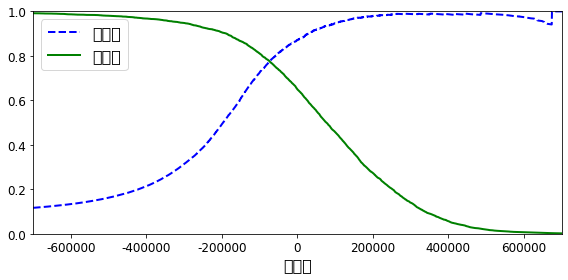

In [140]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="정밀도", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="재현율", linewidth=2)
    plt.xlabel("임계값", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
save_fig("precision_recall_vs_threshold_plot")
plt.show()

In [142]:
(y_train_pred == (y_scores > 0)).all()

True

In [143]:
y_train_pred_90 = (y_scores > 70000)

In [144]:
precision_score(y_train_5, y_train_pred_90)

0.9309882747068676

In [145]:
recall_score(y_train_5, y_train_pred_90)

0.5126360450101457

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 51116 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 54788 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 50984 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 51221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 48128 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 46020 missing from c

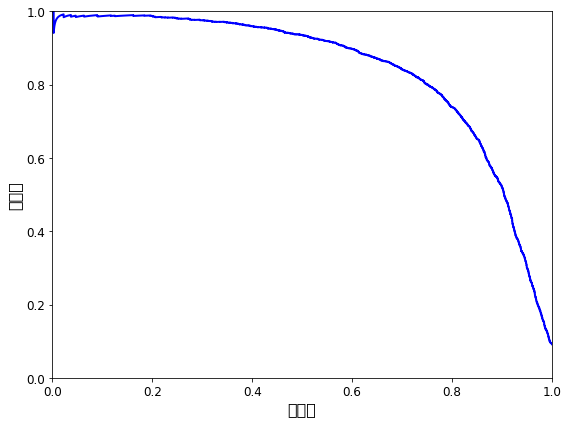

In [146]:
# 재현율 80% 근처에서 정밀도가 급격하게 줄어들기 시작합니다. 이 하강점 직전을 정밀도/ 재현율 트레이드 오프 지점으로 보는 것이 좋습니다.
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("재현율", fontsize=16)
    plt.ylabel("정밀도", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
save_fig("precision_vs_recall_plot")
plt.show()

# ROC 곡선

In [147]:
# ROC 곡선은 정밀도에 대한 재현율 곡선이 아니고(F1), 거짓 양성 비율(FPR)에 대한 진짜 양성 비율(TPR)의 곡선
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

# ROC = TPR / FPR = TPR / (1 - TNR) = RECALL / 1 - TNR
# FPR = FP / FP + TN = ... = 1 - TNR
# TPR = TP / TP + FN = 진짜 양성 비율 = RECALL(재현률)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 44144 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 51667 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 50577 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 49457 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 48708 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 50984 missing from c

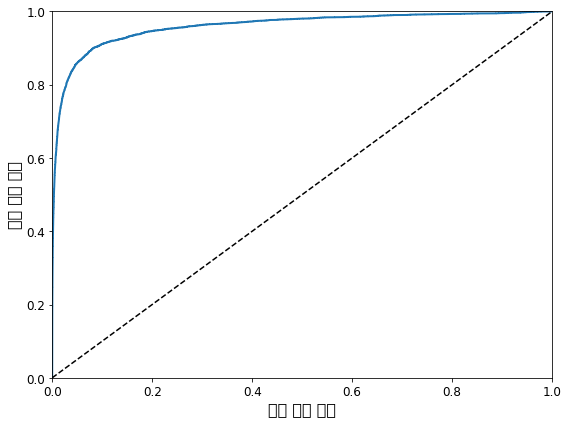

In [150]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('거짓 양성 비율', fontsize=16)
    plt.ylabel('진짜 양성 비율', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
save_fig("roc_curve_plot")
plt.show()

In [151]:
# 곡선 아래의 면적을 이용해서 분류기를 비교할 수 있다. AUC가 1이 좋은 함수, 0.5가 완전 랜덤한 그래프이다.
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9598058535696421

랜덤 포레스트 `n_estimator` 매개변수의 기본값이 0.22 버전에서 10에서 100으로 변경될 예정입니다. 경고를 피하기 위해서 `n_estimator=10`으로 지정합니다.

In [152]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=10, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [153]:
y_scores_forest = y_probas_forest[:, 1] # 점수는 양상 클래스의 확률입니다
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 44144 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 51667 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 50577 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 49457 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 48708 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 50984 missing from c

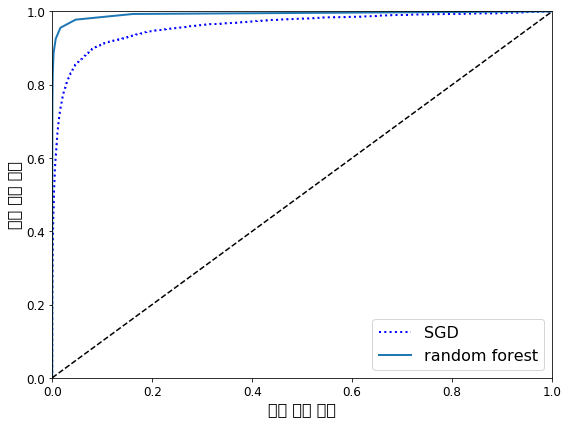

In [155]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "random forest")
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

In [156]:
# 랜덤 포레스트로 돌리면 지표가 매우 높게 나온다(그만큼 예측을 잘해낸다)
roc_auc_score(y_train_5, y_scores_forest)


0.9928250745111685

In [157]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9870386643233744

In [158]:
recall_score(y_train_5, y_train_pred_forest)

0.8288138719793396

## 다중 분류
* 이진 분류기를 여러 개 이용해서 다중 클래스로 분류하는 경우도 많습니다.
* 일대 다 전략 : 이미지를 분류할 때 각 분류기의 점수 중에서 가장 높은 것을 클래스로 선택한다.
* 일대 일 전략 : 모든 숫자의 조합마다 이진 분류기를 훈련시킨다.

In [160]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([9])

In [175]:
# 가장 높은 점수가 우리가 찾고자 하는 클래스의 값이 된다.
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-780634.17445014, -367988.10902669, -857510.2219226 ,
        -109587.17435534,   -6978.239532  , -120352.38122307,
        -785831.32198027, -377771.38059503, -198143.6559996 ,
         107815.22648992]])

In [177]:
np.argmax(some_digit_scores)

9

In [178]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [179]:
sgd_clf.classes_[9]

9

In [180]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packag

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packag

array([4])

In [181]:
len(ovo_clf.estimators_)

45

In [182]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([9])

In [183]:
forest_clf.predict_proba([some_digit])

array([[0. , 0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0.9]])

In [173]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.83935, 0.85125, 0.8676 ])

In [184]:
# 간단하게 입력의 스케일을 조정하면 정확도를 90% 이상으로 높일 수 있습니다.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.91155, 0.91005, 0.9095 ])

## 3.5 에러 분석
* 오차 행렬을 이용하여 예측을 만들고 오차 행렬로 정확도를 표현

In [185]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([[5722,    2,   28,    9,    8,   49,   51,   11,   41,    2],
       [   2, 6494,   47,   23,    6,   42,    5,   10,  100,   13],
       [  51,   37, 5360,   88,   82,   23,   96,   56,  149,   16],
       [  51,   37,  149, 5318,    2,  248,   37,   57,  134,   98],
       [  19,   25,   39,    8, 5378,    7,   54,   29,   77,  206],
       [  73,   42,   35,  170,   73, 4622,  105,   30,  177,   94],
       [  31,   24,   43,    2,   43,   88, 5635,    4,   47,    1],
       [  20,   20,   65,   27,   58,   11,    6, 5806,   12,  240],
       [  53,  147,   78,  164,   11,  163,   56,   24, 5017,  138],
       [  42,   27,   25,   87,  175,   34,    3,  201,   85, 5270]],
      dtype=int64)

In [186]:
def plot_confusion_matrix(matrix):
    """컬러 오차 행렬을 원할 경우"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

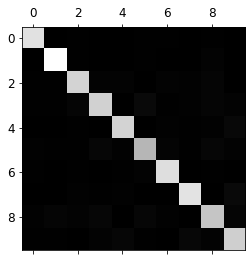

In [187]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

In [188]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

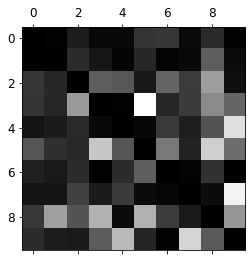

In [189]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()

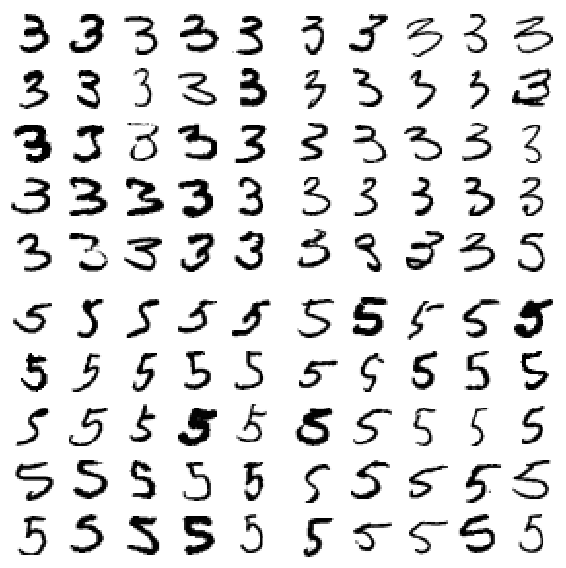

In [190]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
save_fig("error_analysis_digits_plot")
plt.show()

## 다중 레이블 분류
* 여러 개의 이진 레이블을 출력하는 분류 시스템을 다중 레이블 분류 시스템이라고 한다.

In [191]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [192]:
knn_clf.predict([some_digit])

array([[ True,  True]])

**경고**: 다음 셀은 실행하는데 매우 오래 걸립니다(하드웨어에 따라 몇 시간이 걸릴 수 있습니다).

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3, n_jobs=-1)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

# 다중 출력 분류

In [193]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [194]:
noise

array([[ 5,  2, 16, ..., 58, 96, 10],
       [90, 54, 49, ..., 28, 36, 66],
       [35, 34, 28, ..., 67, 95, 93],
       ...,
       [67, 42, 38, ..., 37, 86, 47],
       [74, 58, 46, ..., 60, 35, 23],
       [99, 87, 38, ..., 95, 56, 48]])

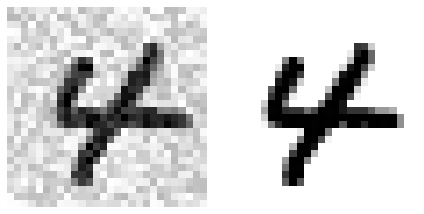

In [195]:
# 이미지 살펴보기
some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
save_fig("noisy_digit_example_plot")
plt.show()

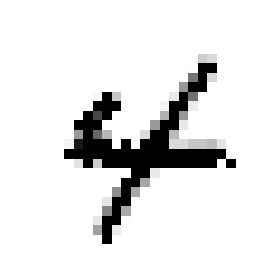

In [196]:
# 이미지 피팅하기
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)
save_fig("cleaned_digit_example_plot")

# 추가 내용

## 더미 (즉, 랜덤) 분류기

In [78]:
from sklearn.dummy import DummyClassifier
dmy_clf = DummyClassifier()
y_probas_dmy = cross_val_predict(dmy_clf, X_train, y_train_5, cv=3, method="predict_proba")
y_scores_dmy = y_probas_dmy[:, 1]

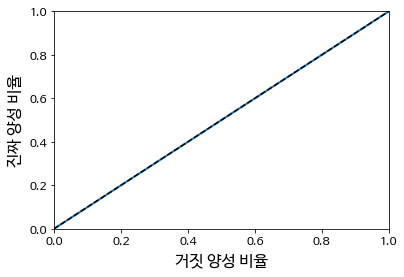

In [79]:
fprr, tprr, thresholdsr = roc_curve(y_train_5, y_scores_dmy)
plot_roc_curve(fprr, tprr)

## KNN 분류기

In [80]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_jobs=-1, weights='distance', n_neighbors=4)
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
                     weights='distance')

In [81]:
y_knn_pred = knn_clf.predict(X_test)

In [82]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_knn_pred)

0.9714

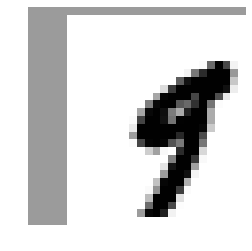

In [83]:
from scipy.ndimage.interpolation import shift
def shift_digit(digit_array, dx, dy, new=0):
    return shift(digit_array.reshape(28, 28), [dy, dx], cval=new).reshape(784)

plot_digit(shift_digit(some_digit, 5, 1, new=100))

In [84]:
X_train_expanded = [X_train]
y_train_expanded = [y_train]
for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    shifted_images = np.apply_along_axis(shift_digit, axis=1, arr=X_train, dx=dx, dy=dy)
    X_train_expanded.append(shifted_images)
    y_train_expanded.append(y_train)

X_train_expanded = np.concatenate(X_train_expanded)
y_train_expanded = np.concatenate(y_train_expanded)
X_train_expanded.shape, y_train_expanded.shape

((300000, 784), (300000,))

In [85]:
knn_clf.fit(X_train_expanded, y_train_expanded)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
                     weights='distance')

In [86]:
y_knn_expanded_pred = knn_clf.predict(X_test)

In [87]:
accuracy_score(y_test, y_knn_expanded_pred)

0.9763

In [88]:
ambiguous_digit = X_test[2589]
knn_clf.predict_proba([ambiguous_digit])

array([[0.24579675, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.75420325]])

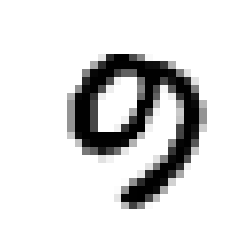

In [89]:
plot_digit(ambiguous_digit)

# 연습문제 해답

## 1. 97% 정확도의 MNIST 분류기

In [90]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 122.9min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=-1,
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [91]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [92]:
grid_search.best_score_

0.9731333333333333

In [93]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

0.9714

## 2. 데이터 증식

In [94]:
from scipy.ndimage.interpolation import shift

In [95]:
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

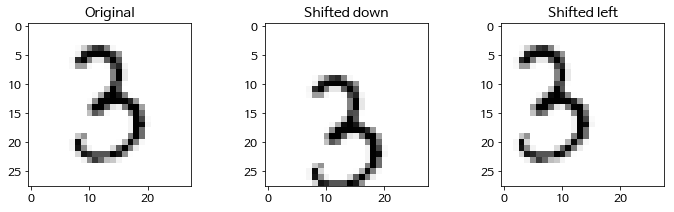

In [96]:
image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

In [97]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [98]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [99]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)

In [100]:
knn_clf.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='distance')

In [101]:
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9763

간단한 데이터 증식으로 0.5%의 정확도가 향상되었습니다. :)

## 3. 타이타닉 데이터셋에 도전

승객의 나이, 성별, 승객 등급, 승선 위치 같은 속성을 기반으로 하여 승객의 생존 여부를 예측하는 것이 목표입니다.

먼저 [캐글](https://www.kaggle.com)에 로그인 하고 [타이타닉 챌린지](https://www.kaggle.com/c/titanic)에서 `train.csv`와 `test.csv`를 다운로드합니다. 두 파일을 `datasets/titanic` 디렉토리에 저장하세요.

그다음 데이터를 적재합니다:

In [102]:
import os

TITANIC_PATH = os.path.join("datasets", "titanic")

In [103]:
import pandas as pd

def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

In [104]:
train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")

데이터는 이미 훈련 세트와 테스트 세트로 분리되어 있습니다. 그러나 테스트 데이터는 레이블을 가지고 있지 않습니다: 훈련 데이터를 이용하여 가능한 최고의 모델을 만들고 테스트 데이터에 대한 예측을 캐글(Kaggle)에 업로드하여 최종 점수를 확인하는 것이 목표입니다.

훈련 세트에서 맨 위 몇 개의 열을 살펴 보겠습니다:

In [105]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


속성은 다음과 같은 의미를 가집니다:
* **Survived**: 타깃입니다. 0은 생존하지 못한 것이고 1은 생존을 의미합니다.
* **Pclass**: 승객 등급. 1, 2, 3등석.
* **Name**, **Sex**, **Age**: 이름 그대로 의미입니다.
* **SibSp**: 함께 탑승한 형제, 배우자의 수.
* **Parch**: 함께 탑승한 자녀, 부모의 수.
* **Ticket**: 티켓 아이디
* **Fare**: 티켓 요금 (파운드)
* **Cabin**: 객실 번호
* **Embarked**: 승객이 탑승한 곳. C(Cherbourg), Q(Queenstown), S(Southampton)

누락된 데이터가 얼마나 되는지 알아보겠습니다:

In [106]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


괜찮네요. **Age**, **Cabin**, **Embarked** 속성의 일부가 null입니다(891개의 non-null 보다 작습니다). 특히 **Cabin**은 77%가 null입니다. 일단 **Cabin**은 무시하고 나머지를 활용하겠습니다. **Age**는 19%가 null이므로 이를 어떻게 처리할지 결정해야 합니다. null을 중간 나이로 바꾸는 것이 괜찮아 보입니다.

**Name**과 **Ticket** 속성도 값을 가지고 있지만 머신러닝 모델이 사용할 수 있는 숫자로 변환하는 것이 조금 까다롭습니다. 그래서 지금은 이 두 속성을 무시하겠습니다.

통계치를 살펴 보겠습니다:

In [107]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


* 이크, 38%만 **Survived**입니다. :( 거의 40%에 가까우므로 정확도를 사용해 모델을 평가해도 괜찮을 것 같습니다.
* 평균 **Fare**는 32.20 파운드라 그렇게 비싸보이지는 않습니다(아마 요금을 많이 반환해 주었기 때문일 것입니다)
* 평균 **Age**는 30보다 작습니다.

타깃이 0과 1로 이루어졌는지 확인합니다:

In [108]:
train_data["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

범주형 특성들을 확인해 보겠습니다:

In [109]:
train_data["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [110]:
train_data["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [111]:
train_data["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

**Embarked** 특성은 승객이 탑승한 곳을 알려 줍니다: C=Cherbourg, Q=Queenstown, S=Southampton.

`CategoricalEncoder` 클래스는 범주형 특성을 원-핫 벡터로 변환시켜 줍니다. 이 클래스는 사이킷런 0.20에 포함될 예정이지만 지금은 아래 코드를 사용합니다([#9151](https://github.com/scikit-learn/scikit-learn/pull/9151) 풀 리퀘스트에서 복사했습니다).

In [112]:
# PR #9151에서 가져온 CategoricalEncoder 클래스의 정의.
# 이 클래스는 사이킷런 0.20에 포함될 예정입니다.
# 이 셀을 실행하거나 복사해서 사용하세요. 이 코드를 모두 이해할 필요는 없습니다.

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

이제 전처리 파이프라인을 만듭니다. `DataFrame`으로부터 특정 속성만 선택하기 위해 이전 장에서 만든 `DataframeSelector`를 재사용하겠습니다:

In [113]:
from sklearn.base import BaseEstimator, TransformerMixin

# 사이킷런이 DataFrame을 바로 사용하지 못하므로
# 수치형이나 범주형 컬럼을 선택하는 클래스를 만듭니다.
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

숫자 특성을 위한 파이프라인을 만듭니다(`Imputer` 클래스는 0.22 버전에서 삭제될 예정입니다. 0.20 버전에서 추가된 `SimpleImputer`를 사용합니다):

In [114]:
from sklearn.pipeline import Pipeline
#from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(["Age", "SibSp", "Parch", "Fare"])),
        ("imputer", SimpleImputer(strategy="median")),
    ])

In [115]:
num_pipeline.fit_transform(train_data)

array([[22.    ,  1.    ,  0.    ,  7.25  ],
       [38.    ,  1.    ,  0.    , 71.2833],
       [26.    ,  0.    ,  0.    ,  7.925 ],
       ...,
       [28.    ,  1.    ,  2.    , 23.45  ],
       [26.    ,  0.    ,  0.    , 30.    ],
       [32.    ,  0.    ,  0.    ,  7.75  ]])

문자열로된 범주형 열을 위해 별도의 Imputer 클래스가 필요합니다(일반 `Imputer` 클래스는 이를 처리하지 못합니다):

In [116]:
# stackoverflow.com/questions/25239958 에서 착안했습니다
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                       index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

이제 범주형 특성을 위한 파이프라인을 만듭니다:

In [117]:
cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(["Pclass", "Sex", "Embarked"])),
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", CategoricalEncoder(encoding='onehot-dense')),
    ])

### future_encoders.py를 사용한 방법 ==========================

주의: 번역서는 `CategoricalEncoder`를 사용하여 각 범주형 값을 원-핫 벡터로 변경합니다. `OneHotEncoder`를 사용하는 것이 더 낫습니다. 지금은 정수형 범주 입력만 다룰 수 있지만 사이킷런 0.20에서는 문자열 범주 입력도 다룰 수 있을 것입니다(PR #10521). 지금은 `future_encoders.py` 파일에서 임포트하지만 사이킷런 0.20 버전이 릴리스되면 `sklearn.preprocessing`에서 바로 임포팅할 수 있습니다.

0.20에 추가된 `OneHotEncoder`를 사용하도록 코드를 변경합니다.

In [118]:
# from future_encoders import OneHotEncoder
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(["Pclass", "Sex", "Embarked"])),
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

0.20 버전에 추가된 `SimpleImputer` 클래스에는 `most_frequent` 옵션을 사용할 수 있습니다:

In [119]:
cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(["Pclass", "Sex", "Embarked"])),
        ("imputer", SimpleImputer(strategy='most_frequent')),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

### ====================================================

In [120]:
cat_pipeline.fit_transform(train_data)

array([[0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

마지막으로 숫자와 범주형 파이프라인을 연결합니다:

In [121]:
from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

사이킷런 0.20 버전에 추가된 `ColumnTransformer`를 사용하면 더 간단히 전처리 파이프라인을 구성할 수 있습니다.

In [122]:
from sklearn.compose import ColumnTransformer

num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median"))
    ])

cat_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy='most_frequent')),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

preprocess_pipeline = ColumnTransformer([
        ("num_pipeline", num_pipeline, ["Age", "SibSp", "Parch", "Fare"]),
        ("cat_pipeline", cat_pipeline, ["Pclass", "Sex", "Embarked"]),
    ])

좋습니다! 이제 원본 데이터를 받아 머신러닝 모델에 주입할 숫자 입력 특성을 출력하는 전처리 파이프라인을 만들었습니다.

In [123]:
X_train = preprocess_pipeline.fit_transform(train_data)
X_train

array([[22.,  1.,  0., ...,  0.,  0.,  1.],
       [38.,  1.,  0., ...,  1.,  0.,  0.],
       [26.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [28.,  1.,  2., ...,  0.,  0.,  1.],
       [26.,  0.,  0., ...,  1.,  0.,  0.],
       [32.,  0.,  0., ...,  0.,  1.,  0.]])

레이블을 가져옵니다:

In [124]:
y_train = train_data["Survived"]

이제 분류기를 훈련시킬 차례입니다. 먼저 `SVC`를 사용해 보겠습니다:

In [125]:
from sklearn.svm import SVC

svm_clf = SVC(gamma='auto')
svm_clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

모델이 잘 훈련된 것 같습니다. 이를 사용해서 테스트 세트에 대한 예측을 만듭니다:

In [126]:
X_test = preprocess_pipeline.transform(test_data)
y_pred = svm_clf.predict(X_test)

이 예측 결과를 (캐글에서 기대하는 형태인) CSV 파일로 만들어 업로드하고 평가를 받아볼 수 있습니다. 하지만 그냥 좋을거라 기대하는 것보다 교차 검증으로 모델이 얼마나 좋은지 평가하는 것이 좋습니다.

In [127]:
from sklearn.model_selection import cross_val_score

svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.7365250822835092

정확도가 73% 이상입니다. 확실히 무작위로 선택한 것보다는 좋습니다. 하지만 아주 높은 점수는 아닙니다. 캐글에서 타이타닉 경연 대회의 [리더보드](https://www.kaggle.com/c/titanic/leaderboard)를 보면 상위 10%내에 들려면 80% 이상의 정확도를 내야합니다. 어떤 사람들은 100%를 달성했습니다. 하지만 타이타닉의 [희생자 목록](https://www.encyclopedia-titanica.org/titanic-victims/)을 쉽게 찾을 수 있으므로 머신러닝을 사용하지 않고도 이런 정확도를 달성할 수 있습니다! ;-) 우리는 80% 정도의 정확도를 내는 모델을 만들어 보겠습니다.

`RandomForestClassifier`를 적용해 보겠습니다:

In [128]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=10, random_state=42)
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8115690614005221

훨씬 좋네요!

10 폴드 교차 검증에 대한 평균 정확도를 보는 대신 모델에서 얻은 10개의 점수를 1사분위, 3사분위를 명료하게 표현해주는 상자 수염 그림(box-and-whisker) 그래프를 만들어 보겠습니다(이 방식을 제안해 준 Nevin Yilmaz에게 감사합니다). `boxplot()` 함수는 이상치(플라이어(flier)라고 부릅니다)를 감지하고 수염 부분에 이를 포함시키지 않습니다. 1사분위가 $Q_1$이고 3사분위가 $Q_3$이라면 사분위수 범위는 $IQR = Q_3 - Q_1$가 됩니다(이 값이 박스의 높이가 됩니다). $Q_1 - 1.5 \times IQR$ 보다 낮거나 $Q3 + 1.5 \times IQR$ 보다 높은 점수는 이상치로 간주됩니다.

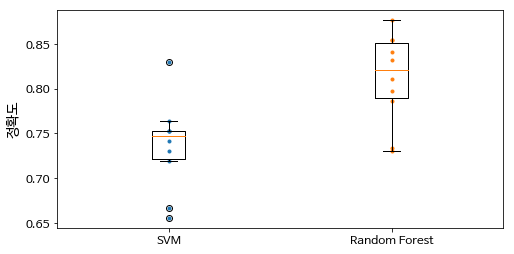

In [129]:
plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM","Random Forest"))
plt.ylabel("정확도", fontsize=14)
plt.show()

이 결과를 더 향상시키려면:
* 교차 검증과 그리드 탐색을 사용하여 더 많은 모델을 비교하고 하이퍼파라미터를 튜닝하세요.
* 특성 공학을 더 시도해 보세요, 예를 들면:
  * **SibSp**와 **Parch**을 이 두 특성의 합으로 바꿉니다.
  * **Survived** 특성과 관련된 이름을 구별해 보세요(가령, 이름에 "Countess"가 있는 경우 생존할 가능성이 높습니다).
* 수치 특성을 범주형 특성으로 바꾸어 보세요: 예를 들어, 나이대가 다른 경우 다른 생존 비율을 가질 수 있습니다(아래 참조). 그러므로 나이 구간을 범주로 만들어 나이 대신 사용하는 것이 도움이 될 수 있스니다. 비슷하게 생존자의 30%가 혼자 여행하는 사람이기 때문에 이들을 위한 특별한 범주를 만드는 것이 도움이 될 수 있습니다(아래 참조).

In [130]:
train_data["AgeBucket"] = train_data["Age"] // 15 * 15
train_data[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean()

,Survived
AgeBucket,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


In [131]:
train_data["RelativesOnboard"] = train_data["SibSp"] + train_data["Parch"]
train_data[["RelativesOnboard", "Survived"]].groupby(['RelativesOnboard']).mean()

,Survived
RelativesOnboard,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


## 4. 스팸 필터

먼저 데이터를 다운받습니다:

In [132]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "http://spamassassin.apache.org/old/publiccorpus/"
HAM_URL = DOWNLOAD_ROOT + "20030228_easy_ham.tar.bz2"
SPAM_URL = DOWNLOAD_ROOT + "20030228_spam.tar.bz2"
SPAM_PATH = os.path.join("datasets", "spam")

def fetch_spam_data(spam_url=SPAM_URL, spam_path=SPAM_PATH):
    if not os.path.isdir(spam_path):
        os.makedirs(spam_path)
    for filename, url in (("ham.tar.bz2", HAM_URL), ("spam.tar.bz2", SPAM_URL)):
        path = os.path.join(spam_path, filename)
        if not os.path.isfile(path):
            urllib.request.urlretrieve(url, path)
        tar_bz2_file = tarfile.open(path)
        tar_bz2_file.extractall(path=SPAM_PATH)
        tar_bz2_file.close()

In [133]:
fetch_spam_data()

다음, 모든 이메일을 읽어 들입니다:

In [134]:
HAM_DIR = os.path.join(SPAM_PATH, "easy_ham")
SPAM_DIR = os.path.join(SPAM_PATH, "spam")
ham_filenames = [name for name in sorted(os.listdir(HAM_DIR)) if len(name) > 20]
spam_filenames = [name for name in sorted(os.listdir(SPAM_DIR)) if len(name) > 20]

In [135]:
len(ham_filenames)

2500

In [136]:
len(spam_filenames)

500

파이썬의 `email` 모듈을 사용해 이메일을 파싱합니다(헤더, 인코딩 등을 처리합니다):

In [137]:
import email
import email.policy

def load_email(is_spam, filename, spam_path=SPAM_PATH):
    directory = "spam" if is_spam else "easy_ham"
    with open(os.path.join(spam_path, directory, filename), "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

In [138]:
ham_emails = [load_email(is_spam=False, filename=name) for name in ham_filenames]
spam_emails = [load_email(is_spam=True, filename=name) for name in spam_filenames]

데이터가 어떻게 구성되어 있는지 감을 잡기 위해 햄 메일과 스팸 메일을 하나씩 보겠습니다:

In [139]:
print(ham_emails[1].get_content().strip())

Martin A posted:
Tassos Papadopoulos, the Greek sculptor behind the plan, judged that the
 limestone of Mount Kerdylio, 70 miles east of Salonika and not far from the
 Mount Athos monastic community, was ideal for the patriotic sculpture. 
 
 As well as Alexander's granite features, 240 ft high and 170 ft wide, a
 museum, a restored amphitheatre and car park for admiring crowds are
planned
---------------------
So is this mountain limestone or granite?
If it's limestone, it'll weather pretty fast.

------------------------ Yahoo! Groups Sponsor ---------------------~-->
4 DVDs Free +s&p Join Now
http://us.click.yahoo.com/pt6YBB/NXiEAA/mG3HAA/7gSolB/TM
---------------------------------------------------------------------~->

To unsubscribe from this group, send an email to:
forteana-unsubscribe@egroups.com

 

Your use of Yahoo! Groups is subject to http://docs.yahoo.com/info/terms/


In [140]:
print(spam_emails[6].get_content().strip())

Help wanted.  We are a 14 year old fortune 500 company, that is
growing at a tremendous rate.  We are looking for individuals who
want to work from home.

This is an opportunity to make an excellent income.  No experience
is required.  We will train you.

So if you are looking to be employed from home with a career that has
vast opportunities, then go:

http://www.basetel.com/wealthnow

We are looking for energetic and self motivated people.  If that is you
than click on the link and fill out the form, and one of our
employement specialist will contact you.

To be removed from our link simple go to:

http://www.basetel.com/remove.html


4139vOLW7-758DoDY1425FRhM1-764SMFc8513fCsLl40


어떤 이메일은 이미지나 첨부 파일을 가진 멀티파트(multipart)입니다(메일에 포함되어 있을수 있습니다). 어떤 파일들이 있는지 살펴 보겠습니다:

In [141]:
def get_email_structure(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        return "multipart({})".format(", ".join([
            get_email_structure(sub_email)
            for sub_email in payload
        ]))
    else:
        return email.get_content_type()

In [142]:
from collections import Counter

def structures_counter(emails):
    structures = Counter()
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1
    return structures

In [143]:
structures_counter(ham_emails).most_common()

[('text/plain', 2408),
 ('multipart(text/plain, application/pgp-signature)', 66),
 ('multipart(text/plain, text/html)', 8),
 ('multipart(text/plain, text/plain)', 4),
 ('multipart(text/plain)', 3),
 ('multipart(text/plain, application/octet-stream)', 2),
 ('multipart(text/plain, text/enriched)', 1),
 ('multipart(text/plain, application/ms-tnef, text/plain)', 1),
 ('multipart(multipart(text/plain, text/plain, text/plain), application/pgp-signature)',
  1),
 ('multipart(text/plain, video/mng)', 1),
 ('multipart(text/plain, multipart(text/plain))', 1),
 ('multipart(text/plain, application/x-pkcs7-signature)', 1),
 ('multipart(text/plain, multipart(text/plain, text/plain), text/rfc822-headers)',
  1),
 ('multipart(text/plain, multipart(text/plain, text/plain), multipart(multipart(text/plain, application/x-pkcs7-signature)))',
  1),
 ('multipart(text/plain, application/x-java-applet)', 1)]

In [144]:
structures_counter(spam_emails).most_common()

[('text/plain', 218),
 ('text/html', 183),
 ('multipart(text/plain, text/html)', 45),
 ('multipart(text/html)', 20),
 ('multipart(text/plain)', 19),
 ('multipart(multipart(text/html))', 5),
 ('multipart(text/plain, image/jpeg)', 3),
 ('multipart(text/html, application/octet-stream)', 2),
 ('multipart(text/plain, application/octet-stream)', 1),
 ('multipart(text/html, text/plain)', 1),
 ('multipart(multipart(text/html), application/octet-stream, image/jpeg)', 1),
 ('multipart(multipart(text/plain, text/html), image/gif)', 1),
 ('multipart/alternative', 1)]

햄 메일은 평범한 텍스트가 많고 스팸은 HTML일 경우가 많습니다. 적은 수의 햄 이메일이 PGP로 서명되어 있지만 스팸 메일에는 없습니다. 요약하면 이메일 구조는 유용한 정보입니다.

이제 이메일 헤더를 살펴보겠습니다:

In [145]:
for header, value in spam_emails[0].items():
    print(header,":",value)

Return-Path : <12a1mailbot1@web.de>
Delivered-To : zzzz@localhost.spamassassin.taint.org
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.spamassassin.taint.org (Postfix) with ESMTP id 136B943C32	for <zzzz@localhost>; Thu, 22 Aug 2002 08:17:21 -0400 (EDT)
Received : from mail.webnote.net [193.120.211.219]	by localhost with POP3 (fetchmail-5.9.0)	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 13:17:21 +0100 (IST)
Received : from dd_it7 ([210.97.77.167])	by webnote.net (8.9.3/8.9.3) with ESMTP id NAA04623	for <zzzz@spamassassin.taint.org>; Thu, 22 Aug 2002 13:09:41 +0100
From : 12a1mailbot1@web.de
Received : from r-smtp.korea.com - 203.122.2.197 by dd_it7  with Microsoft SMTPSVC(5.5.1775.675.6);	 Sat, 24 Aug 2002 09:42:10 +0900
To : dcek1a1@netsgo.com
Subject : Life Insurance - Why Pay More?
Date : Wed, 21 Aug 2002 20:31:57 -1600
MIME-Version : 1.0
Message-ID : <0103c1042001882DD_IT7@dd_it7>
Content-Type : text/html; charset="iso-8859-1"
Content-Transfer-Encoding : qu

보낸사람의 이메일 주소와 같이 헤더에는 유용한 정보가 많이 있지만 여기서는 `Subject` 헤더만 다뤄 보겠습니다:

In [146]:
spam_emails[0]["Subject"]

'Life Insurance - Why Pay More?'

좋습니다. 데이터에를 더 살펴보기 전에 훈련 세트와 테스트 세트로 나누도록 하겠습니다:

In [147]:
import numpy as np
from sklearn.model_selection import train_test_split

X = np.array(ham_emails + spam_emails)
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

이제 전처리 함수를 작성하겠습니다. 먼저 HTML을 일반 텍스트로 변환하는 함수가 필요합니다. 이 작업에는 당연히 [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/) 라이브러리를 사용하는게 좋지만 의존성을 줄이기 위해서 정규식을 사용하여 대강 만들어 보겠습니다([un̨ho͞ly radiańcé destro҉ying all enli̍̈́̂̈́ghtenment](https://stackoverflow.com/a/1732454/38626)의 위험에도 불구하고). 다음 함수는 `<head>` 섹션을 삭제하고 모든 `<a>` 태그를 HYPERLINK 문자로 바꿉니다. 그런 다음 모든 HTML 태그를 제거하고 텍스트만 남깁니다. 보기 편하게 여러개의 개행 문자를 하나로 만들고 (`&gt;`나 `&nbsp;` 같은) html 엔티티를 복원합니다:

In [148]:
import re
from html import unescape

def html_to_plain_text(html):
    text = re.sub('<head.*?>.*?</head>', '', html, flags=re.M | re.S | re.I)
    text = re.sub('<a\s.*?>', ' HYPERLINK ', text, flags=re.M | re.S | re.I)
    text = re.sub('<.*?>', '', text, flags=re.M | re.S)
    text = re.sub(r'(\s*\n)+', '\n', text, flags=re.M | re.S)
    return unescape(text)

잘 작동하는지 확인해 보겠습니다. 다음은 HTML 스팸입니다:

In [149]:
html_spam_emails = [email for email in X_train[y_train==1]
                    if get_email_structure(email) == "text/html"]
sample_html_spam = html_spam_emails[7]
print(sample_html_spam.get_content().strip()[:1000], "...")

<HTML><HEAD><TITLE></TITLE><META http-equiv="Content-Type" content="text/html; charset=windows-1252"><STYLE>A:link {TEX-DECORATION: none}A:active {TEXT-DECORATION: none}A:visited {TEXT-DECORATION: none}A:hover {COLOR: #0033ff; TEXT-DECORATION: underline}</STYLE><META content="MSHTML 6.00.2713.1100" name="GENERATOR"></HEAD>
<BODY text="#000000" vLink="#0033ff" link="#0033ff" bgColor="#CCCC99"><TABLE borderColor="#660000" cellSpacing="0" cellPadding="0" border="0" width="100%"><TR><TD bgColor="#CCCC99" valign="top" colspan="2" height="27">
<font size="6" face="Arial, Helvetica, sans-serif" color="#660000">
<b>OTC</b></font></TD></TR><TR><TD height="2" bgcolor="#6a694f">
<font size="5" face="Times New Roman, Times, serif" color="#FFFFFF">
<b>&nbsp;Newsletter</b></font></TD><TD height="2" bgcolor="#6a694f"><div align="right"><font color="#FFFFFF">
<b>Discover Tomorrow's Winners&nbsp;</b></font></div></TD></TR><TR><TD height="25" colspan="2" bgcolor="#CCCC99"><table width="100%" border="0" 

변환된 텍스트입니다:

In [150]:
print(html_to_plain_text(sample_html_spam.get_content())[:1000], "...")


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Watch for analyst "Strong Buy Recommendations" and several advisory newsletters picking CBYI.  CBYI has filed to be traded on the OTCBB, share prices historically INCREASE when companies get listed on this larger trading exchange. CBYI is trading around 25 cents and should skyrocket to $2.66 - $3.25 a share in the near future.
Put CBYI on your watch list, acquire a position TODAY.
REASONS TO INVEST IN CBYI
A profitable company and is on track to beat ALL earnings estimates!
One of the FASTEST growing distributors in environmental & safety equipment instruments.
Excellent management team, several EXCLUSIVE contracts.  IMPRESSIVE client list including the U.S. Air Force, Anheuser-Busch, Chevron Refining and Mitsubishi Heavy Industries, GE-Energy & Environmental Research.
RAPIDLY GROWING INDUSTRY
Industry revenues exceed $900 million, estimates indicate that there could be as much as $25 billi

아주 좋습니다! 이제 포맷에 상관없이 이메일을 입력으로 받아서 일반 텍스트를 출력하는 함수를 만들겠습니다:

In [151]:
def email_to_text(email):
    html = None
    for part in email.walk():
        ctype = part.get_content_type()
        if not ctype in ("text/plain", "text/html"):
            continue
        try:
            content = part.get_content()
        except: # in case of encoding issues
            content = str(part.get_payload())
        if ctype == "text/plain":
            return content
        else:
            html = content
    if html:
        return html_to_plain_text(html)

In [152]:
print(email_to_text(sample_html_spam)[:100], "...")


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Wat ...


어간 추출을 해보죠! 이 작업을 하려면 자연어 처리 툴킷([NLTK](http://www.nltk.org/))을 설치해야 합니다. 다음 명령으로 간단히 설치할 수 있습니다(먼저 virtualenv 환경을 활성화시켜야 합니다. 별도의 환경이 없다면 어드민 권한이 필요할지 모릅니다. 아니면 `--user` 옵션을 사용하세요):

`$ pip install nltk`

In [153]:
try:
    import nltk

    stemmer = nltk.PorterStemmer()
    for word in ("Computations", "Computation", "Computing", "Computed", "Compute", "Compulsive"):
        print(word, "=>", stemmer.stem(word))
except ImportError:
    print("Error: stemming requires the NLTK module.")
    stemmer = None

Computations => comput
Computation => comput
Computing => comput
Computed => comput
Compute => comput
Compulsive => compuls


인터넷 주소는 "URL" 문자로 바꾸겠습니다. [정규식](https://mathiasbynens.be/demo/url-regex)을 하드 코딩할 수도 있지만 [urlextract](https://github.com/lipoja/URLExtract) 라이브러리를 사용하겠습니다. 다음 명령으로 설치합니다(먼저 virtualenv 환경을 활성화시켜야 합니다. 별도의 환경이 없다면 어드민 권한이 필요할지 모릅니다. 아니면 `--user` 옵션을 사용하세요):

`$ pip install urlextract`

In [154]:
try:
    import urlextract # 루트 도메인 이름을 다운로드하기 위해 인터넷 연결이 필요할지 모릅니다
    
    url_extractor = urlextract.URLExtract()
    print(url_extractor.find_urls("Will it detect github.com and https://youtu.be/7Pq-S557XQU?t=3m32s"))
except ImportError:
    print("Error: replacing URLs requires the urlextract module.")
    url_extractor = None

['github.com', 'https://youtu.be/7Pq-S557XQU?t=3m32s']


이들을 모두 하나의 변환기로 연결하여 이메일을 단어 카운트로 바꿀 것입니다. 파이썬의 `split()` 메서드를 사용하면 구둣점과 단어 경계를 기준으로 문장을 단어로 바꿉니다. 이 방법이 많은 언어에 통하지만 전부는 아닙니다. 예를 들어 중국어와 일본어는 일반적으로 단어 사이에 공백을 두지 않습니다. 베트남어는 음절 사이에 공백을 두기도 합니다. 여기서는 데이터셋이 (거의) 영어로 되어 있기 때문에 문제없습니다.

In [155]:
from sklearn.base import BaseEstimator, TransformerMixin

class EmailToWordCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, strip_headers=True, lower_case=True, remove_punctuation=True,
                 replace_urls=True, replace_numbers=True, stemming=True):
        self.strip_headers = strip_headers
        self.lower_case = lower_case
        self.remove_punctuation = remove_punctuation
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers
        self.stemming = stemming
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_transformed = []
        for email in X:
            text = email_to_text(email) or ""
            if self.lower_case:
                text = text.lower()
            if self.replace_urls and url_extractor is not None:
                urls = list(set(url_extractor.find_urls(text)))
                urls.sort(key=lambda url: len(url), reverse=True)
                for url in urls:
                    text = text.replace(url, " URL ")
            if self.replace_numbers:
                text = re.sub(r'\d+(?:\.\d*(?:[eE]\d+))?', 'NUMBER', text)
            if self.remove_punctuation:
                text = re.sub(r'\W+', ' ', text, flags=re.M)
            word_counts = Counter(text.split())
            if self.stemming and stemmer is not None:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    stemmed_word = stemmer.stem(word)
                    stemmed_word_counts[stemmed_word] += count
                word_counts = stemmed_word_counts
            X_transformed.append(word_counts)
        return np.array(X_transformed)

이 변환기를 몇 개의 이메일에 적용해 보겠습니다:

In [156]:
X_few = X_train[:3]
X_few_wordcounts = EmailToWordCounterTransformer().fit_transform(X_few)
X_few_wordcounts

array([Counter({'chuck': 1, 'murcko': 1, 'wrote': 1, 'stuff': 1, 'yawn': 1, 'r': 1}),
       Counter({'the': 11, 'of': 9, 'and': 8, 'all': 3, 'christian': 3, 'to': 3, 'by': 3, 'jefferson': 2, 'i': 2, 'have': 2, 'superstit': 2, 'one': 2, 'on': 2, 'been': 2, 'ha': 2, 'half': 2, 'rogueri': 2, 'teach': 2, 'jesu': 2, 'some': 1, 'interest': 1, 'quot': 1, 'url': 1, 'thoma': 1, 'examin': 1, 'known': 1, 'word': 1, 'do': 1, 'not': 1, 'find': 1, 'in': 1, 'our': 1, 'particular': 1, 'redeem': 1, 'featur': 1, 'they': 1, 'are': 1, 'alik': 1, 'found': 1, 'fabl': 1, 'mytholog': 1, 'million': 1, 'innoc': 1, 'men': 1, 'women': 1, 'children': 1, 'sinc': 1, 'introduct': 1, 'burnt': 1, 'tortur': 1, 'fine': 1, 'imprison': 1, 'what': 1, 'effect': 1, 'thi': 1, 'coercion': 1, 'make': 1, 'world': 1, 'fool': 1, 'other': 1, 'hypocrit': 1, 'support': 1, 'error': 1, 'over': 1, 'earth': 1, 'six': 1, 'histor': 1, 'american': 1, 'john': 1, 'e': 1, 'remsburg': 1, 'letter': 1, 'william': 1, 'short': 1, 'again': 1, 'becom

제대로 작동하는 것 같네요!

이제 단어 카운트를 벡터로 변환해야 합니다. 이를 위해서 또 다른 변환기를 만들겠습니다. 이 변환기는 (자주 나타나는 단어 순으로 정렬된) 어휘 목록을 구축하는 `fit()` 메서드와 어휘 목록을 사용해 단어를 벡터로 바꾸는 `transform()` 메서드를 가집니다. 출력은 희소 행렬이 됩니다.

In [157]:
from scipy.sparse import csr_matrix

class WordCounterToVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size=1000):
        self.vocabulary_size = vocabulary_size
    def fit(self, X, y=None):
        total_count = Counter()
        for word_count in X:
            for word, count in word_count.items():
                total_count[word] += min(count, 10)
        most_common = total_count.most_common()[:self.vocabulary_size]
        self.most_common_ = most_common
        self.vocabulary_ = {word: index + 1 for index, (word, count) in enumerate(most_common)}
        return self
    def transform(self, X, y=None):
        rows = []
        cols = []
        data = []
        for row, word_count in enumerate(X):
            for word, count in word_count.items():
                rows.append(row)
                cols.append(self.vocabulary_.get(word, 0))
                data.append(count)
        return csr_matrix((data, (rows, cols)), shape=(len(X), self.vocabulary_size + 1))

In [158]:
vocab_transformer = WordCounterToVectorTransformer(vocabulary_size=10)
X_few_vectors = vocab_transformer.fit_transform(X_few_wordcounts)
X_few_vectors

<3x11 sparse matrix of type '<class 'numpy.int64'>'
	with 20 stored elements in Compressed Sparse Row format>

In [159]:
X_few_vectors.toarray()

array([[ 6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [99, 11,  9,  8,  1,  3,  3,  1,  3,  2,  3],
       [63,  0,  1,  2,  5,  3,  1,  2,  0,  1,  0]], dtype=int64)

이 행렬은 무엇을 의미하나요? 세 번째 행의 첫 번째 열의 65는 세 번째 이메일이 어휘 목록에 없는 단어를 65개 가지고 있다는 뜻입니다. 그 다음의 0은 어휘 목록에 있는 첫 번째 단어가 한 번도 등장하지 않는다는 뜻이고 그 다음의 1은 한 번 나타난다는 뜻입니다. 이 단어들이 무엇인지 확인하려면 어휘 목록을 보면 됩니다. 첫 번째 단어는 "the"이고 두 번째 단어는 "of"입니다.

In [160]:
vocab_transformer.vocabulary_

{'the': 1,
 'of': 2,
 'and': 3,
 'url': 4,
 'to': 5,
 'all': 6,
 'in': 7,
 'christian': 8,
 'on': 9,
 'by': 10}

이제 스팸 분류기를 훈련시킬 준비를 마쳤습니다! 전체 데이터셋을 변환시켜보죠:

In [161]:
from sklearn.pipeline import Pipeline

preprocess_pipeline = Pipeline([
    ("email_to_wordcount", EmailToWordCounterTransformer()),
    ("wordcount_to_vector", WordCounterToVectorTransformer()),
])

X_train_transformed = preprocess_pipeline.fit_transform(X_train)

In [162]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

log_clf = LogisticRegression(solver='liblinear', random_state=42)
score = cross_val_score(log_clf, X_train_transformed, y_train, cv=3, verbose=3)
score.mean()

[CV]  ................................................................
[CV] .................................... , score=0.984, total=   0.0s
[CV]  ................................................................
[CV] .................................... , score=0.983, total=   0.0s
[CV]  ................................................................
[CV] .................................... , score=0.991, total=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished


0.9858333333333333

98.7%가 넘네요. 첫 번째 시도치고 나쁘지 않습니다! :) 그러나 이 데이터셋은 비교적 쉬운 문제입니다. 더 어려운 데이터셋에 적용해 보면 결과가 그리 높지 않을 것입니다. 여러개의 모델을 시도해 보고 제일 좋은 것을 골라 교차 검증으로 세밀하게 튜닝해 보세요.

하지만 전체 내용을 파악했으므로 여기서 멈추겠습니다. 테스트 세트에서 정밀도/재현율을 출력해 보겠습니다:

In [163]:
from sklearn.metrics import precision_score, recall_score

X_test_transformed = preprocess_pipeline.transform(X_test)

log_clf = LogisticRegression(solver='liblinear', random_state=42)
log_clf.fit(X_train_transformed, y_train)

y_pred = log_clf.predict(X_test_transformed)

print("정밀도: {:.2f}%".format(100 * precision_score(y_test, y_pred)))
print("재현율: {:.2f}%".format(100 * recall_score(y_test, y_pred)))

정밀도: 94.90%
재현율: 97.89%
